<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Absorption_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 6.6 MB/s 


In [48]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import csv
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare, chi2

def fit(x, b, l):
  return b*np.exp(-x/l)


def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

# Influence of Projection

To generate random $(\theta, \phi)$ coordinates on a spherical cap with and aperture angle, $\alpha$, with two unimform random numbers $r_1,r_2 \in [0,1]$, we define:

$$\theta=2π \times r_1$$
$$\phi = \arccos[(1−\cos\alpha)\times r_2+\cos\alpha] $$

Reference: https://math.stackexchange.com/questions/2076415/points-on-surface-of-spherical-cap

The radius of each point, $\rho$, is given by the distance travelled in the medium, $d$, which depends on the absorption length, $\lambda$: 

$$A = \exp(-d/\lambda)$$

and is calculated from a third random number, $r_3$:

$$\rho = - \lambda \ln(r_3)$$

From this, the $(x,y,z)$ coordinates where calculated, as well as the real distance between each point and the source, $d=\sqrt{x^2+ y^2+z^2}$, as well as the projection of the point, $p=\sqrt{x^2+ y^2}$ (without considering the $z$-coordinate).

The real distances, $d$, and projections, $p$, are then histogramed and fitted to equation $f(x)=b\times \exp(-x/\lambda)$, to validate the true $\lambda$ generation, and determine the effective $\lambda$, respectively.

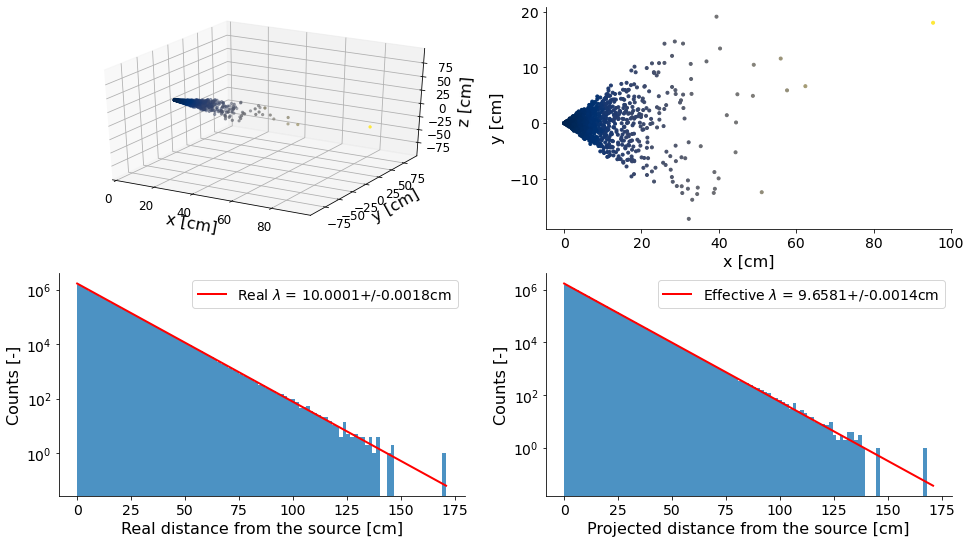

In [3]:
#@title Single $\lambda$ visualization

#@markdown In this cell, we can visualise and calculate the effective 
#@markdown $\lambda$ distribution for a given aperture and $\lambda$.

def single_lambda(real_lambda, degree):
  runs = 10000000
  aperture = degree* np.pi/180
  theta = np.random.uniform(low=0, high=2*np.pi, size= runs)
  phi = np.arccos((1-np.cos(aperture)) * np.random.uniform(low=0, high=1, size= runs) + np.cos(aperture))
  rho = -real_lambda * np.log(np.random.uniform(low=0, high=1, size= runs))
  z = rho * np.cos(theta) * np.sin(phi)
  y = rho * np.sin(theta) * np.sin(phi)
  x = rho * np.cos(phi)
  proj = np.sqrt(x**2 + y**2)
  d = np.sqrt(x**2 + y**2 + z**2)

  fig = plt.figure(figsize=(16, 9))

  ax1 = fig.add_subplot(2, 2, 1, projection='3d')
  ax1.scatter3D(x[:1000], y[:1000], z[:1000], c=d[:1000], marker='.', cmap='cividis')
  ax1.set_xlim(0,np.max(d[:1000]))
  ax1.set_ylim(-np.max(d[:1000]),np.max(d[:1000]))
  ax1.set_zlim(-np.max(d[:1000]),np.max(d[:1000]))
  ax1.set_xlabel('x [cm]', fontsize=16)
  ax1.set_ylabel('y [cm]', fontsize=16)
  ax1.set_zlabel('z [cm]', fontsize=16)
  ax1.tick_params(axis='both', which='major', labelsize=12)

  ax2 = fig.add_subplot(2, 2, 2)
  ax2.scatter(x[:1000],y[:1000], c=d[:1000], marker='.', cmap='cividis')
  ax2.set_xlabel('x [cm]', fontsize=16)
  ax2.set_ylabel('y [cm]', fontsize=16)
  ax2.tick_params(axis='both', which='major', labelsize=14)
  ax2.spines["right"].set_visible(False)
  ax2.spines["top"].set_visible(False)
  
  ax3 = fig.add_subplot(2, 2, 3)
  x = np.arange(0,np.max(d), 0.01)
  n, bins, patches =  ax3.hist(d, bins=100, align='mid', color='tab:blue', alpha=0.8)
  bin_middles = (bins[1:]+bins[:-1])/2
  popt, pcov = curve_fit(fit, bin_middles, n, p0=[1e6, 10])
  pcov = np.sqrt(np.diag(pcov))
  ycalc = fit(x, *popt)
  ax3.plot(x,ycalc, color='r', lw=2, label='Real $\lambda$ = '+str(ufloat(popt[1], pcov[1]))+'cm')
  ax3.semilogy()
  ax3.legend(fontsize=14)
  ax3.set_xlabel('Real distance from the source [cm]', fontsize=16)
  ax3.set_ylabel('Counts [-]', fontsize=16)
  ax3.tick_params(axis='both', which='major', labelsize=14)
  ax3.spines["right"].set_visible(False)
  ax3.spines["top"].set_visible(False)

  ax4 = fig.add_subplot(2, 2, 4)
  n, bins, patches =  ax4.hist(proj, bins=100, align='mid', color='tab:blue', alpha=0.8)
  bin_middles = (bins[1:]+bins[:-1])/2
  popt, pcov = curve_fit(fit, bin_middles, n, p0=[10000, 1])
  pcov = np.sqrt(np.diag(pcov))
  ycalc = fit(x, *popt)
  ax4.plot(x,ycalc, color='r', lw=2, label='Effective $\lambda$ = '+str(ufloat(popt[1], pcov[1]))+'cm')
  ax4.semilogy()
  ax4.legend(fontsize=14)
  ax4.set_xlabel('Projected distance from the source [cm]', fontsize=16)
  ax4.set_ylabel('Counts [-]', fontsize=16)
  ax4.tick_params(axis='both', which='major', labelsize=14)
  ax4.spines["right"].set_visible(False)
  ax4.spines["top"].set_visible(False)

  plt.show

Absorption_length =  10#@param {type:"raw"}

Aperture =  30#@param {type:"raw"}

single_lambda(Absorption_length, Aperture)

In [4]:
#@title Get file for different $\lambda$s and apertures

#@markdown In this cell, we can generate a .csv file with effective $\lambda$s for an array of different apertures and $\lambda$s.

#@markdown No visualisation is given for the sake of speed.

# open the file in the write mode
f = open('/content/drive/MyDrive/LIME/effective_lambda.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(['Aperture [º]', 'Input Lambda', 'Real Lambda', 'uReal Lambda', 'Effective Lambda', 'uEffective Lambda'])

for real_lambda in [43.91, 83.04, 192.68, 527.10, 3394.46]:
  for degree in [5,10,15,20,25,30,35,40,45]:
    runs = 100000000
    aperture = degree* np.pi/180
    theta = np.random.uniform(low=0, high=2*np.pi, size= runs)
    phi = np.arccos((1-np.cos(aperture)) * np.random.uniform(low=0, high=1, size= runs) + np.cos(aperture))
    rho = -real_lambda * np.log(np.random.uniform(low=0, high=1, size= runs))
    z = rho * np.cos(theta) * np.sin(phi)
    y = rho * np.sin(theta) * np.sin(phi)
    x = rho * np.cos(phi)
    proj = np.sqrt(x**2 + y**2)
    d = np.sqrt(x**2 + y**2 + z**2)

    hist, bins = np.histogram(d, bins=100)
    bins = (bins[1:]+bins[:-1])/2
    popt, pcov = curve_fit(fit, bins, hist, p0=[1e6, 1000])
    pcov = np.sqrt(np.diag(pcov))
    true = ufloat(popt[1], pcov[1])

    hist, bins = np.histogram(proj, bins=100)
    bins = (bins[1:]+bins[:-1])/2
    popt, pcov = curve_fit(fit, bins, hist, p0=[1e6, 1000])
    pcov = np.sqrt(np.diag(pcov))
    effective = ufloat(popt[1], pcov[1])
    writer.writerow([degree, real_lambda, true.n, true.s, effective.n, effective.s])

# close the file
f.close()

In [5]:
#@title Load the results file

results = pd.read_csv('/content/drive/MyDrive/LIME/effective_lambda.csv')
results.head()

,Aperture [º],Input Lambda,Real Lambda,uReal Lambda,Effective Lambda,uEffective Lambda
0,5,43.91,43.897661,0.001897,43.855491,0.001898
1,10,43.91,43.919504,0.003007,43.752334,0.002932
2,15,43.91,43.920357,0.003369,43.543743,0.003623
3,20,43.91,43.902422,0.002996,43.233845,0.003071
4,25,43.91,43.916798,0.002087,42.871434,0.002124


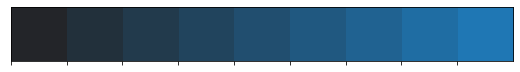

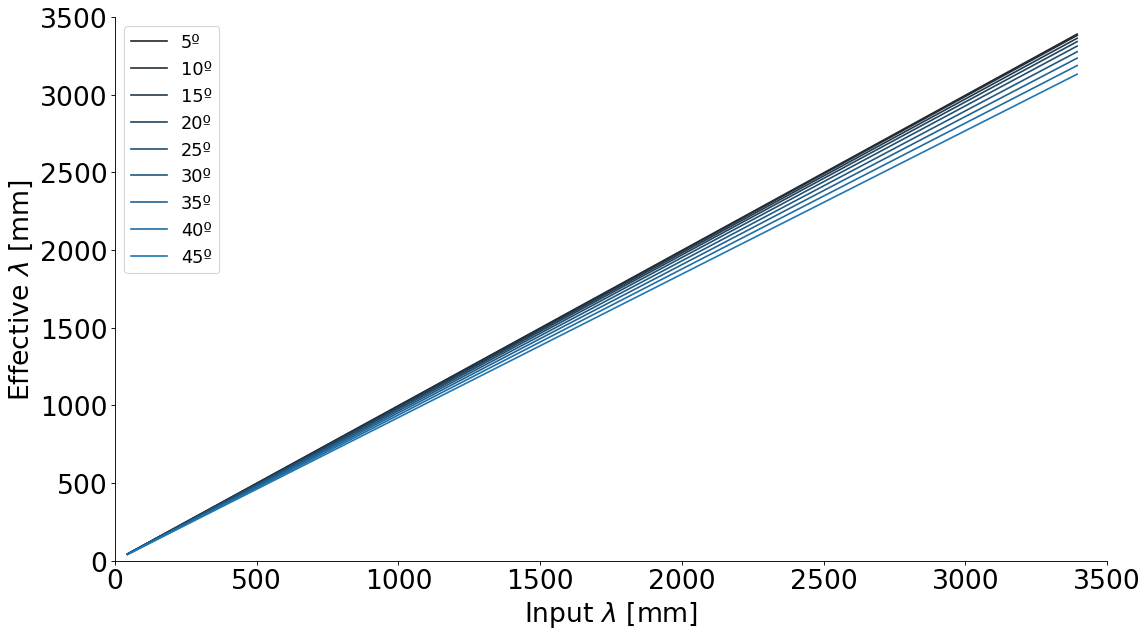

In [6]:
#@title Effective $\lambda$ in function of the input $\lambda$, for different appertures
#@markdown As the aperture angle increases, the effective $\lambda$ decreases relatively to the input $\lambda$.
color = get_color(9, 'tab:blue')

fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 

i=0
for aperture in [5,10,15,20,25,30,35,40,45]:
  plt.plot(results['Input Lambda'].loc[results['Aperture [º]']==aperture], 
           results['Effective Lambda'].loc[results['Aperture [º]']==aperture],
           color=color[i], label=str(aperture)+'º')
  i=i+1

ax.set_xlabel('Input $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax.set_ylim(0, 3500)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Effective $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlim(0,3500)
plt.legend(fontsize=16)
plt.show()

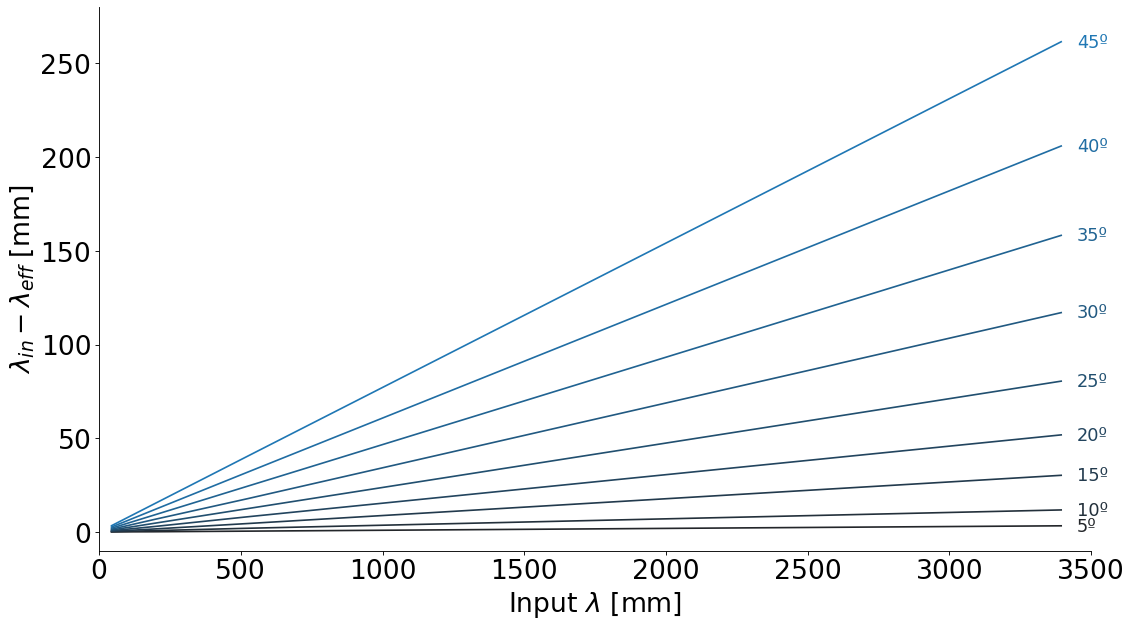

In [7]:
#@title Difference between input and effective $\lambda$ in function of the input $\lambda$, for different appertures
##@markdown As the aperture angle increases, the the difference between the input and effective $\lambda$ increases.

results['Difference'] = results['Input Lambda']-results['Effective Lambda']
fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 

i=0
for aperture in [5,10,15,20,25,30,35,40,45]:
  plt.plot(results['Input Lambda'].loc[results['Aperture [º]']==aperture], 
           results['Difference'].loc[results['Aperture [º]']==aperture],
           color=color[i], label=str(aperture)+'º')
  plt.text(3450, results['Difference'].loc[results['Aperture [º]']==aperture].iloc[-1], 
           str(aperture)+'º', ha='left', fontsize=16, color=color[i], va='center')
  i=i+1

ax.set_xlabel('Input $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax.set_ylim(-10, 280)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('$\lambda_{in}-\lambda_{eff}$ [mm]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlim(0,3500)
#plt.legend(fontsize=16)
plt.show()

Mean relative error for 5 º:  0.102+/-0.019
Mean relative error for 10 º:  0.376+/-0.022
Mean relative error for 15 º:  0.853+/-0.025
Mean relative error for 20 º:  1.534+/-0.017
Mean relative error for 25 º:  2.383+/-0.015
Mean relative error for 30 º:  3.425+/-0.021
Mean relative error for 35 º:  4.6668+/-0.0030
Mean relative error for 40 º:  6.094+/-0.017
Mean relative error for 45 º:  7.714+/-0.008


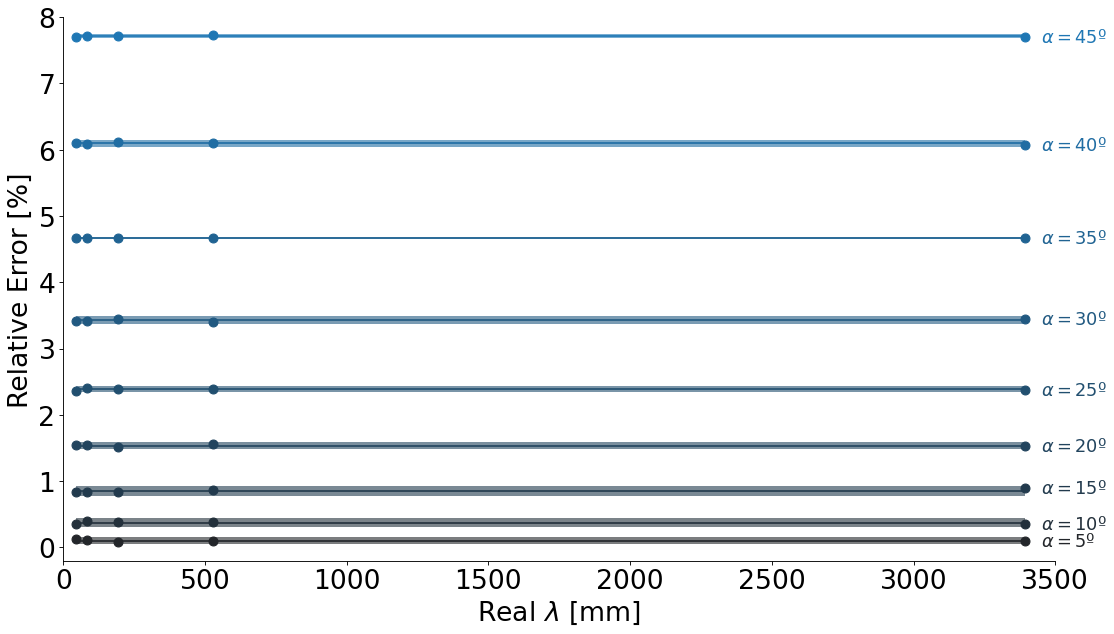

In [41]:
#@title Relative error in the calculation of the effective $\lambda$ as a function of the input $\lambda$, for different appertures
#@markdown The relative error of the effective $\lambda$ only depends on the aperture of the source.

results['Rel. Error'] = (results['Input Lambda']-results['Effective Lambda'])/results['Input Lambda']*100
fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 
alpha = []
error = []
derror = []

i=0
for aperture in [5,10,15,20,25,30,35,40,45]:
  plt.plot(results['Input Lambda'].loc[results['Aperture [º]']==aperture], 
           results['Rel. Error'].loc[results['Aperture [º]']==aperture],
           color=color[i], label=str(aperture)+'º', marker='o', lw=0, markersize=8)
  plt.text(3450, results['Rel. Error'].loc[results['Aperture [º]']==aperture].iloc[-1], 
           r'$\alpha=$'+str(aperture)+'º', ha='left', fontsize=16, color=color[i], va='center')
  plt.hlines(y=results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean(), xmin=43.91, xmax=3394.46, color=color[i])
  plt.fill_between(results['Input Lambda'].loc[results['Aperture [º]']==aperture],
                   results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean()-3*results['Rel. Error'].loc[results['Aperture [º]']==aperture].std(),
                   results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean()+3*results['Rel. Error'].loc[results['Aperture [º]']==aperture].std(),
                   color=color[i], lw=0, alpha=0.6)
  print('Mean relative error for', aperture, 'º: ', ufloat(results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean(), 
               results['Rel. Error'].loc[results['Aperture [º]']==aperture].std()))
  alpha.append(aperture)
  error.append(results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean())
  derror.append(results['Rel. Error'].loc[results['Aperture [º]']==aperture].std())
  i=i+1

ax.set_xlabel('Real $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax.set_ylim(-0.2, 8)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Relative Error [%]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlim(0,3500)
#plt.legend(fontsize=16)
plt.show()

a = 0.00381+/-0.00008
b =  -0.000+/-0.004
c =  0.00+/-0.06


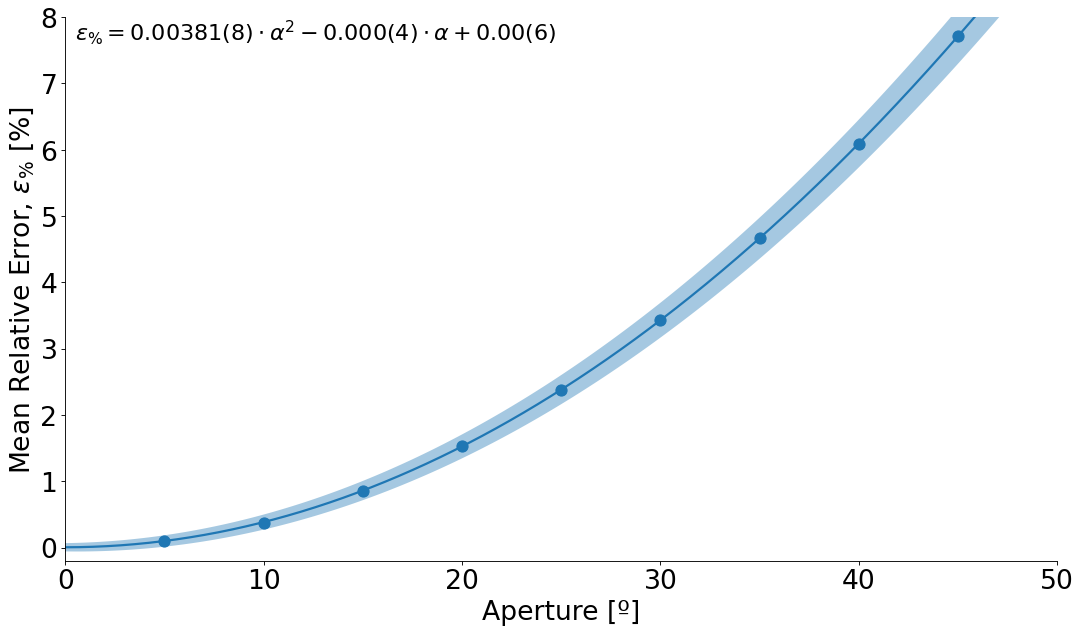

In [79]:
fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 
plt.errorbar(alpha, error, yerr=derror, lw=0, marker='o', markersize=10)

def pol(x, a, b, c):
  return a*x**2+b*x+c

popt, pcov = curve_fit(pol, alpha, error, p0=[1,0.01, 1], absolute_sigma=True, sigma=derror)
ycalc =pol(np.arange(0, 50, 0.1), *popt)
pcov = np.sqrt(np.diag(pcov))
print('a =', ufloat(popt[0], 3*pcov[0]))
print('b = ', ufloat(popt[1], 3*pcov[1]))
print('c = ', ufloat(popt[2], 3*pcov[2]))

bound_upper = pol(np.arange(0, 50, 0.1), *(popt + 3*pcov))
bound_lower = pol(np.arange(0, 50, 0.1), *(popt - 3*pcov))

plt.plot(np.arange(0, 50, 0.1), ycalc, color='tab:blue', lw=2)
plt.fill_between(np.arange(0, 50, 0.1), bound_lower, bound_upper,
                 color = 'tab:blue', alpha = 0.4, lw=0, zorder=2)
plt.text(0.5,8, r'$\epsilon_\% = 0.00381(8) \cdot \alpha ^2-0.000(4) \cdot \alpha +0.00(6)$', ha='left', va='top', fontsize=20)
ax.set_xlabel('Aperture [º]', y=0.5, ha='center', fontsize=24)
ax.set_ylim(-0.2, 8)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Mean Relative Error, $\epsilon_\%$ [%]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlim(0,50)
plt.show()